# Todo
1. Label plots
1. Improve plot2Maps by adding labels and colorbar/range options
1. Save and easily import some standard pre-generated maps
1. Optimise lensing code.

# Suspicions
1. Padding before convolution (need complex FFT)
1. <s>Quicklens uses arctan2(lx, -ly) (tried changing all instances of ly, lx to lx, -ly, no effect)</s>
1. Add noise per Fourier pixel directly

# How it works
* Always begin with `getCambSpectra`.
* Load spectra into a `CMBSpectra` for interpolation.
* Generate `CMBMap`s or a combined `TEB` using `CMBSpectra.generatePrimordialMaps`.
* Detector noise application are defined by `Detector`.
* Lens using `lensTEB`.

In [1]:
from cmb_simulation import *

In [2]:
# getCambSpectra
powers = getCambSpectra()
print(powers.keys())
print(powers['unlensed_scalar'].shape)

dict_keys(['total', 'unlensed_scalar', 'unlensed_total', 'lensed_scalar', 'tensor', 'lens_potential'])
(7051, 4)


# Basics

In [22]:
# get_ls
d = 0.1
N = 9
lx, ly = get_ls(d, N)
print(lx * d*N/2/np.pi)
print(ly * d*N/2/np.pi)
# validate:
# kx goes horizontally (second coord)
# ky goes vertically (first coord)

[[0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]]
[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.]
 [-4. -4. -4. -4. -4.]
 [-3. -3. -3. -3. -3.]
 [-2. -2. -2. -2. -2.]
 [-1. -1. -1. -1. -1.]]


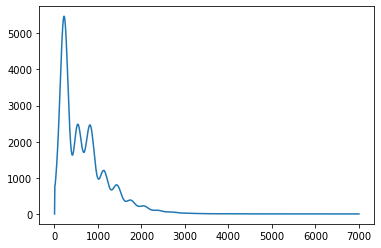

In [3]:
# Spectrum.plot
cmb = CMBSpectra(powers)
ls = np.linspace(1, 7000, 1000)
cmb.TT.plot(ls, scale2)
# validate: see CAMB demo

In [13]:
# elemTensorProd
arr1 = np.random.random((10, 15, 2, 3))
arr2 = np.random.random((10, 15, 4, 5))
prod = elemTensorProd(arr1, arr2)
prod[5,5,1,2,3,4] - arr1[5,5,1,2]*arr2[5,5,3,4]
# validate: 0

0.0

In [12]:
# dotVec
arr = np.random.random((10, 15, 5, 5))
vec = np.random.random((10, 15, 5))
dv = dotVec(arr, vec)
dv2 = np.array([[arr[i,j]@vec[i,j]@vec[i,j] for j in range(15)] for i in range(10)])
dv[5,5] - dv2[5,5]
# validate: 0

0.0

In [16]:
# irfft2
d = 0.0004
N = 200
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
p = cmb.generateLensingPotential(d, N)
stacked = np.zeros((N, N//2+1, 2, 2), dtype='complex_')
stacked[:,:,0,0] = teb.T.f
stacked[:,:,0,1] = teb.E.f
stacked[:,:,1,0] = teb.B.f
stacked[:,:,1,1] = p.f

np.max(np.abs(irfft2(stacked) - np.fft.irfft2(stacked, axes=(0, 1))))
# validate: 0

0.0

In [ ]:
# convolution
d = 0.0004
N = 200
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
p = cmb.generateLensingPotential(d, N)
arr1 = teb.T.f
arr2 = p.f



# Generating maps by sampling

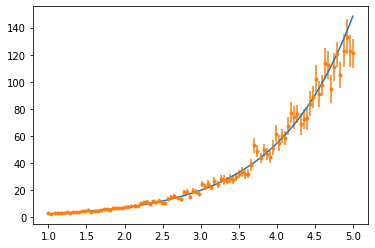

In [56]:
spec = Spectrum(np.exp)
ls = np.linspace(1, 5, 100)
samples = np.array([spec.sample(ls) for _ in range(100)])
means = np.mean((samples*samples.conj()).real, axis=0)
stds = np.std((samples*samples.conj()).real, axis=0)/np.sqrt(100)

spec.plot(ls)
plt.errorbar(ls, means, stds, fmt='.')
plt.show()
# validate: line goes through points, error bars make sense

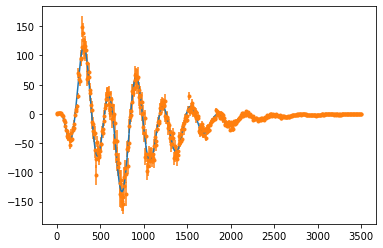

In [57]:
# choleskyUnlensed, sampleCov
cmb = CMBSpectra(powers)
ls = np.linspace(0, 3500, 500)
chol = cmb.choleskyUnlensed(ls)
samples = np.array([sampleCov(chol) for _ in range(100)])
means_TT = np.mean((samples[:,:,0]*samples[:,:,0].conj()).real, axis=0)
stds_TT = np.std((samples[:,:,0]*samples[:,:,0].conj()).real, axis=0)/np.sqrt(100)
means_EE = np.mean((samples[:,:,1]*samples[:,:,1].conj()).real, axis=0)
stds_EE = np.std((samples[:,:,1]*samples[:,:,1].conj()).real, axis=0)/np.sqrt(100)
means_TE = np.mean((samples[:,:,0]*samples[:,:,1].conj()).real, axis=0)
stds_TE = np.std((samples[:,:,0]*samples[:,:,1].conj()).real, axis=0)/np.sqrt(100)

# cmb.TT.plot(ls, lambda l: l**2/(2*np.pi))
# plt.errorbar(ls, means_TT*ls**2/(2*np.pi), stds_TT*ls**2/(2*np.pi), fmt='.')
# cmb.EE.plot(ls, lambda l: l**2/(2*np.pi))
# plt.errorbar(ls, means_EE*ls**2/(2*np.pi), stds_EE*ls**2/(2*np.pi), fmt='.')
cmb.TE.plot(ls, lambda l: l**2/(2*np.pi))
plt.errorbar(ls, means_TE*ls**2/(2*np.pi), stds_TE*ls**2/(2*np.pi), fmt='.')
plt.show()
# validate: curves passes through points, error bars look reasonable

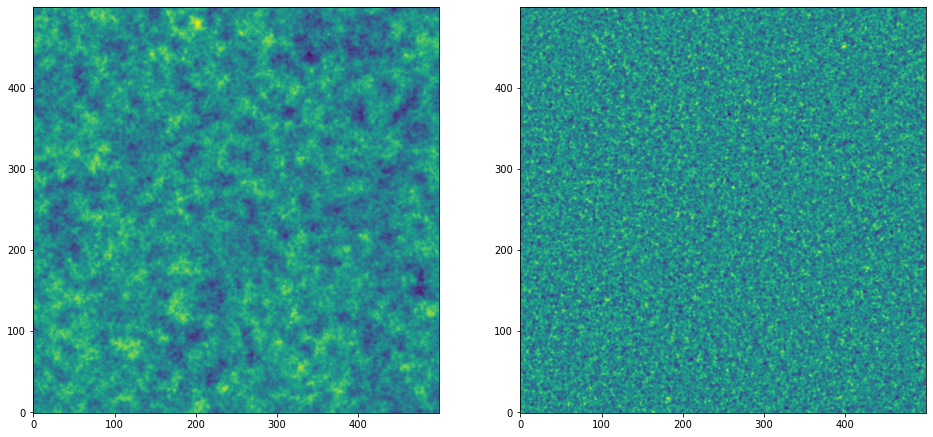

In [5]:
# generatePrimordialMaps, CMBMap.plot
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)

plot2Maps(teb.T.r, teb.E.r)

In [6]:
# temperature fluctuation
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)

np.std(teb.T.r)
# validate: stdev ~ 100 muK

102.6345406560074

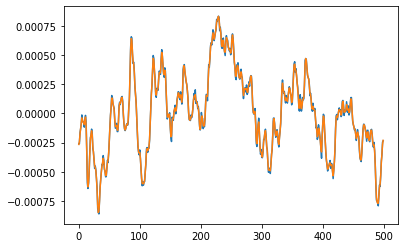

1.8164197875631547

In [7]:
# grad, RMS lensing deflection
d = 0.001
N = 500
cmb = CMBSpectra(powers)
p = cmb.generateLensingPotential(d, N)

px, py = grad(p)
py_np, px_np = np.gradient(p.r, d)

plt.plot(px.r[100])
plt.plot(px_np[100])
plt.show()

np.sqrt(np.mean(px.r**2 + py.r**2)) / np.pi*180*60
# validate: curves overlap
# ~2 arcmin

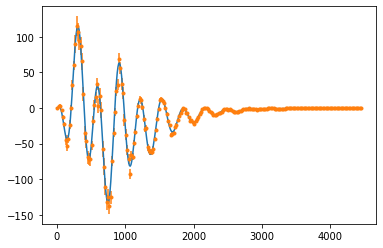

In [8]:
# generatePrimordialMaps, binnedCorrelation
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)

cmb.TE.plot(np.linspace(1, 4200, 400), lambda l: l**2/(2*np.pi))
avg = binnedCorrelation(teb.T, teb.E)
avg.plot(lambda l: l**2/(2*np.pi), fmt='.')
# validate: curve passes through points, error bars are reasonable

In [9]:
# getTQU
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
tqu = teb.getTQU()

lx, ly = get_ls(d, N)
phi_l = np.arctan2(ly, lx)
P1 = teb.E.f + 1j*teb.B.f
P2 = np.exp(-2j*phi_l) * (tqu.Q.f + 1j*tqu.U.f)
np.max(((P1-P2)*(P1-P2).conj()).real)
# validate: difference is tiny

6.617444900424221e-23

In [10]:
# getTEB
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
tqu = teb.getTQU()
teb2 = tqu.getTEB()

np.max(teb.E.r-teb2.E.r)-np.min(teb.E.r-teb2.E.r)
# validate: difference is tiny

2.220446049250313e-14

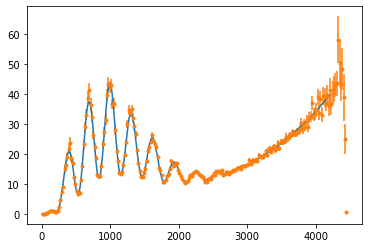

In [11]:
# addNoise
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
simons = Detector(*simons_params)
teb_obs = simons.addNoise(teb)

(cmb.EE + simons.EEn).plot(np.linspace(1, 4200, 500), lambda l: l**2/(2*np.pi))
teb_obs.E.binSpectrum().plot(lambda l: l**2/(2*np.pi), fmt='.')
# validate: curves match and error bars are reasonable

# Lensing

In [12]:
d = 0.0004
N = 1000
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
p = cmb.generateLensingPotential(d, N)

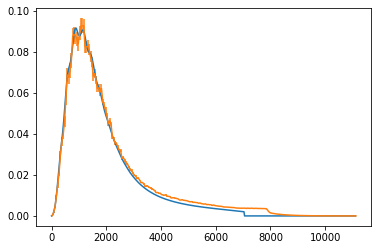

In [17]:
# Lensing by cubic interpolation
teb_len1 = lensTEB(teb, p, fun=lensInterp)

ls = np.linspace(1, np.max(teb_len1.ml), 500)
cmb.BB_len.plot(ls, lambda l: l**2/(2*np.pi))
teb_len1.B.binSpectrum(delta=50).plot(lambda l: l**2/(2*np.pi))
# 2.5s

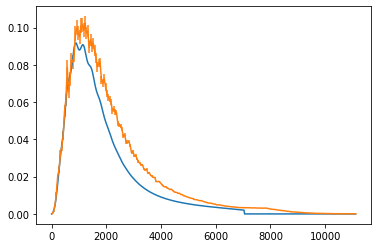

In [14]:
# Lensing by simple Taylor expansion
teb_len2 = lensTEB(teb, p, fun=lensTaylor)

ls = np.linspace(1, np.max(teb_len2.ml), 500)
cmb.BB_len.plot(ls, lambda l: l**2/(2*np.pi))
teb_len2.B.binSpectrum(delta=50).plot(lambda l: l**2/(2*np.pi))
# 1.9s, worse convergence than interp

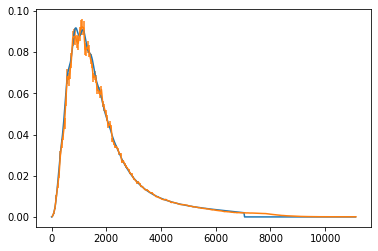

In [18]:
# Lensing by simple Taylor expansion
teb_len3 = lensTEB(teb, p, fun=lensTaylorNearest)

ls = np.linspace(1, np.max(teb_len3.ml), 500)
cmb.BB_len.plot(ls, lambda l: l**2/(2*np.pi))
teb_len3.B.binSpectrum(delta=50).plot(lambda l: l**2/(2*np.pi))
# 10.4s, better convergence than interp

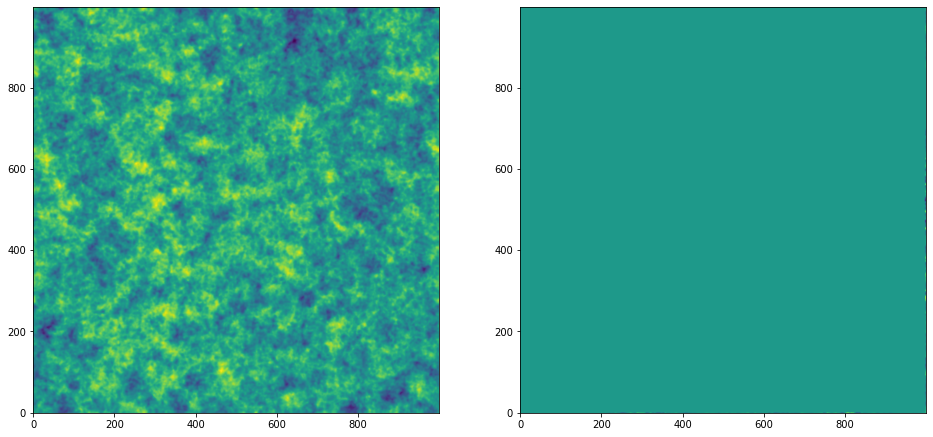

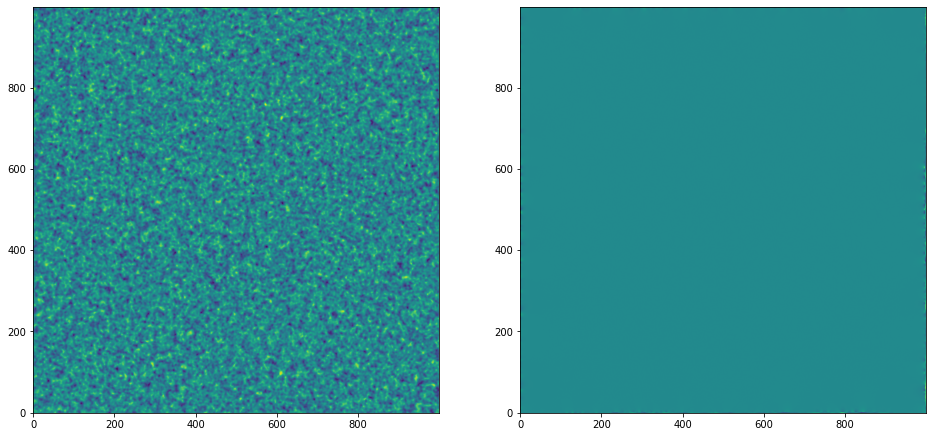

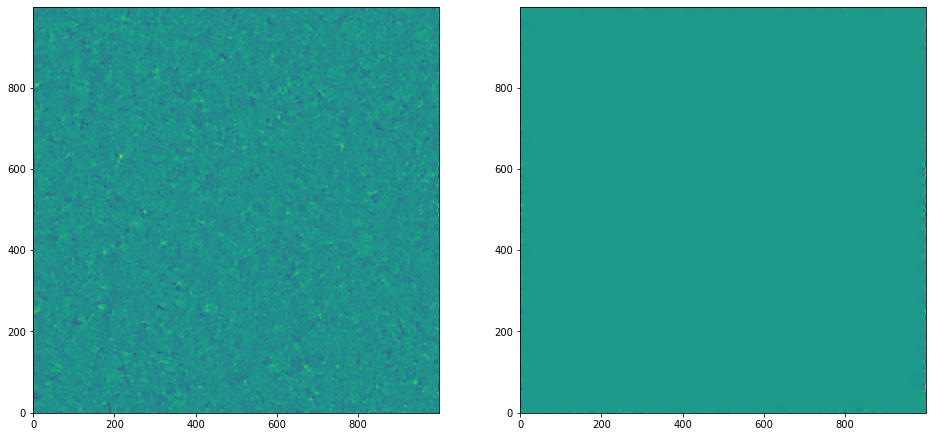

In [16]:
# Interp and Taylor(Nearest) are consistent with each other
plot2Maps(teb_len1.T.r, teb_len3.T.r-teb_len1.T.r)
plot2Maps(teb_len1.E.r, teb_len3.E.r-teb_len1.E.r)
plot2Maps(teb_len1.B.r, teb_len3.B.r-teb_len1.B.r)
# validate: RHS all empty

# Rotation

# Quadratic estimator

In [3]:
d = 1/60/180*np.pi
N = 800
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
p = cmb.generateLensingPotential(d, N)
detector = Detector(*cmb_s4_params)
teb_obs = detector.addNoise(teb)
teb_len = lensTEB(teb, p, lensInterp)
teb_len_obs = detector.addNoise(teb_len)

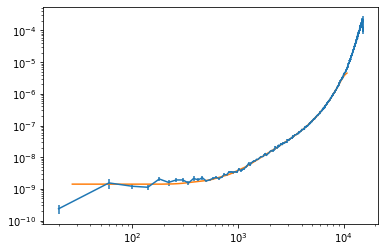

In [4]:
# unlensed
est_unl = LensingEstimator(cmb, teb_obs, detector, lensed=False)
qe_unl = convolveFull(est_unl.qe('EB'), est_unl.ls)
norm_unl = convolveFull(est_unl.norm('EB'), est_unl.ls).real * d**2
norm_unl[0,0] = 1e10
qe_unl_map = CMBMap(d, N, fourier=qe_unl/norm_unl)

qe_unl_map.binSpectrum(delta=40).plot(scale=scale4)
noise_unl = 1/norm_unl
ls = teb.ml[N//2+1:,0]
plt.loglog(ls, noise_unl[N//2+1:,0] * ls**4/(2*np.pi))
plt.show()

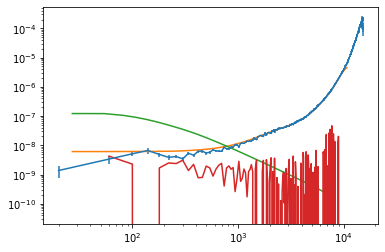

In [5]:
# lensed
est_len = LensingEstimator(cmb, teb_len_obs, detector, lensed=True) # true or false?
qe_len = convolveFull(est_len.qe('EB'), est_len.ls)
norm_len = convolveFull(est_len.norm('EB'), est_len.ls).real * d**2
norm_len[0,0] = 1e10
qe_len_map = CMBMap(d, N, fourier=qe_len/norm_len)

qe_avg = qe_len_map.binSpectrum(delta=40)
qe_avg.plot(scale=scale4)
# binnedCorrelation(p, qe_len_map, delta=40).plot(scale4)
noise_len = 1/norm_len
ls = teb.ml[N//2+1:,0]
plt.loglog(ls, noise_len[N//2+1:,0] * ls**4/(2*np.pi))
cmb.pp.plot(ls, scale=scale4)

noise_interp = interp1d(ls, noise_len[N//2+1:,0], bounds_error=False)
plt.loglog(qe_avg.ls, -(qe_avg.means - noise_interp(qe_avg.ls)) * scale4(qe_avg.ls))

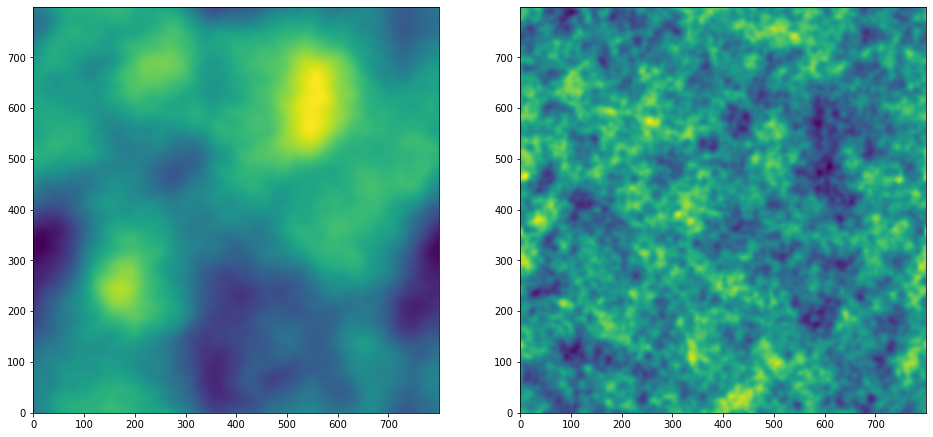

In [9]:
plot2Maps(p.r, qe_len_map.r)

# Testing

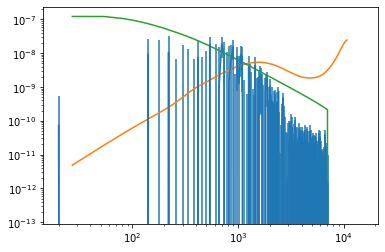

In [8]:
# qe_len_map.binSpectrum(delta=40).plot(scale=scale4)
p_conj = CMBMap(d, N, fourier=p.f.conj())
binnedCorrelation(qe_len_map, p_conj, delta=40).plot(scale=scale4)
noise_len = 1/norm_len
ls = teb.ml[N//2+1:,0]
plt.loglog(ls, noise_len[N//2+1:,0] * ls**4/(2*np.pi))
cmb.pp.plot(ls, scale=scale4)

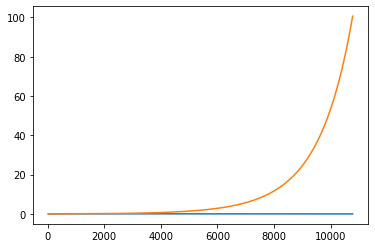

In [18]:
ls = est_len.ml[N//2+1:,0]
plt.plot(ls, est_len.BB[N//2+1:,0] * scale2(ls))
plt.plot(ls, est_len.BB_t[N//2+1:,0] * scale2(ls))

In [41]:
lx, ly = get_ls(d, N)
ml = modl(lx, ly)
C_TT = cmb.TT_len(ml)
C_TT_t = C_TT + detector.TTn(ml)
ones = np.ones((N, N//2+1))

# estimator
est_term1_factor1_x = teb_len.T.f * C_TT * lx / C_TT_t / 2
est_term1_factor1_y = teb_len.T.f * C_TT * ly / C_TT_t / 2
est_term1_factor2 = teb_len.T.f / C_TT_t
est_term2_factor1 = teb_len.T.f / C_TT_t / 2
est_term2_factor2_x = teb_len.T.f * C_TT * lx / C_TT_t
est_term2_factor2_y = teb_len.T.f * C_TT * ly / C_TT_t

# normalisation
norm_term1_factor1_xx = C_TT**2 * lx * lx / C_TT_t / 2 / d**4
norm_term1_factor1_xy = C_TT**2 * lx * ly / C_TT_t / 2 / d**4
norm_term1_factor1_yx = C_TT**2 * ly * lx / C_TT_t / 2 / d**4
norm_term1_factor1_yy = C_TT**2 * ly * ly / C_TT_t / 2 / d**4
norm_term1_factor2 = 1 / C_TT_t
norm_term2_factor1_x = 2 * C_TT * lx / C_TT_t / 2 / d**4
norm_term2_factor1_y = 2 * C_TT * ly / C_TT_t / 2 / d**4
norm_term2_factor2_x = C_TT * lx / C_TT_t
norm_term2_factor2_y = C_TT * ly / C_TT_t
norm_term3_factor1 = 1 / C_TT_t / 2 / d**4
norm_term3_factor2_xx = C_TT**2 * lx * lx / C_TT_t
norm_term3_factor2_xy = C_TT**2 * lx * ly / C_TT_t
norm_term3_factor2_yx = C_TT**2 * ly * lx / C_TT_t
norm_term3_factor2_yy = C_TT**2 * ly * ly / C_TT_t

# irfft2
est_term1_factor1_x_r = np.fft.irfft2(est_term1_factor1_x)
est_term1_factor1_y_r = np.fft.irfft2(est_term1_factor1_y)
est_term1_factor2_r = np.fft.irfft2(est_term1_factor2)
est_term2_factor1_r = np.fft.irfft2(est_term2_factor1)
est_term2_factor2_x_r = np.fft.irfft2(est_term2_factor2_x)
est_term2_factor2_y_r = np.fft.irfft2(est_term2_factor2_y)
norm_term1_factor1_xx_r = np.fft.irfft2(norm_term1_factor1_xx)
norm_term1_factor1_xy_r = np.fft.irfft2(norm_term1_factor1_xy)
norm_term1_factor1_yx_r = np.fft.irfft2(norm_term1_factor1_yx)
norm_term1_factor1_yy_r = np.fft.irfft2(norm_term1_factor1_yy)
norm_term1_factor2_r = np.fft.irfft2(norm_term1_factor2)
norm_term2_factor1_x_r = np.fft.irfft2(norm_term2_factor1_x)
norm_term2_factor1_y_r = np.fft.irfft2(norm_term2_factor1_y)
norm_term2_factor2_x_r = np.fft.irfft2(norm_term2_factor2_x)
norm_term2_factor2_y_r = np.fft.irfft2(norm_term2_factor2_y)
norm_term3_factor1_r = np.fft.irfft2(norm_term3_factor1)
norm_term3_factor2_xx_r = np.fft.irfft2(norm_term3_factor2_xx)
norm_term3_factor2_xy_r = np.fft.irfft2(norm_term3_factor2_xy)
norm_term3_factor2_yx_r = np.fft.irfft2(norm_term3_factor2_yx)
norm_term3_factor2_yy_r = np.fft.irfft2(norm_term3_factor2_yy)

# convolution
est_term1_x = np.fft.rfft2(est_term1_factor1_x_r * est_term1_factor2_r)
est_term1_y = np.fft.rfft2(est_term1_factor1_y_r * est_term1_factor2_r)
est_term2_x = np.fft.rfft2(est_term2_factor1_r * est_term2_factor2_x_r)
est_term2_y = np.fft.rfft2(est_term2_factor1_r * est_term2_factor2_y_r)
norm_term1_xx = np.fft.rfft2(norm_term1_factor1_xx_r * norm_term1_factor2_r)
norm_term1_xy = np.fft.rfft2(norm_term1_factor1_xy_r * norm_term1_factor2_r)
norm_term1_yx = np.fft.rfft2(norm_term1_factor1_yx_r * norm_term1_factor2_r)
norm_term1_yy = np.fft.rfft2(norm_term1_factor1_yy_r * norm_term1_factor2_r)
norm_term2_xx = np.fft.rfft2(norm_term2_factor1_x_r * norm_term2_factor2_x_r)
norm_term2_xy = np.fft.rfft2(norm_term2_factor1_x_r * norm_term2_factor2_y_r)
norm_term2_yx = np.fft.rfft2(norm_term2_factor1_y_r * norm_term2_factor2_x_r)
norm_term2_yy = np.fft.rfft2(norm_term2_factor1_y_r * norm_term2_factor2_y_r)
norm_term3_xx = np.fft.rfft2(norm_term3_factor1_r * norm_term3_factor2_xx_r)
norm_term3_xy = np.fft.rfft2(norm_term3_factor1_r * norm_term3_factor2_xy_r)
norm_term3_yx = np.fft.rfft2(norm_term3_factor1_r * norm_term3_factor2_yx_r)
norm_term3_yy = np.fft.rfft2(norm_term3_factor1_r * norm_term3_factor2_yy_r)

# dot with L
est_term1 = est_term1_x * lx + est_term1_y * ly
est_term2 = est_term2_x * lx + est_term2_y * ly
est = est_term1 + est_term2
norm_term1 = norm_term1_xx * lx * lx + norm_term1_xy * lx * ly + norm_term1_yx * ly * lx + norm_term1_yy * ly * ly
norm_term2 = norm_term2_xx * lx * lx + norm_term2_xy * lx * ly + norm_term2_yx * ly * lx + norm_term2_yy * ly * ly
norm_term3 = norm_term3_xx * lx * lx + norm_term3_xy * lx * ly + norm_term3_yx * ly * lx + norm_term3_yy * ly * ly
norm = (norm_term1 + norm_term2 + norm_term3) * d**2

norm[0,0] = 1e5
est_TT_map = CMBMap(d, N, fourier=est / norm)

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


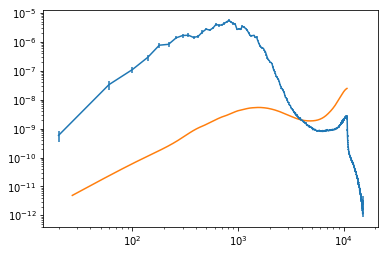

In [42]:
est_TT_map.binSpectrum(40).plot(scale4)
ls = ml[N//2+1:,0]
plt.loglog(ls, 1/norm[N//2+1:,0] * ls**4/(2*np.pi))